# DS207: Spotify Genre Classification Project
#### SEC2 - Nicholas Lin, Yoni Nackash, Rex Gao

## Introduction & Context

asdf

## Data Preprocessing

In [1]:
# Import the libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report

pd.set_option('display.max_columns', None)

In [2]:
#loading the data
raw_df = pd.read_csv('spotify_tracks_dataset.csv')
raw_df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [3]:
df = raw_df.copy()
print('Shape of dataframe:', df.shape)

# Remove null row
print('Step 1: Removing rows with NA')
df.dropna(inplace=True)

# Map explicit field to binary
df['explicit'] = df['explicit'].apply(lambda x: 1 if x == True else 0)

# Remove "Unnamed: 0" field, and remove any duplicate tracks
print("Step 2: Drop 'Unnamed: 0' column, and remove duplicate tracks")
df = df.drop(columns = ["Unnamed: 0"])
df = df.drop_duplicates()

# Keep tracks with only 1 labeled genre
print('Step 3: Drop tracks with more than one assigned genre')
num_tracks_ids = df['track_id'].value_counts()
single_tracks_ids = num_tracks_ids[num_tracks_ids==1].index.tolist()
df = df[df['track_id'].isin(single_tracks_ids)]

#Extra drop duplicates based on artists & track_name instead of track_id
print('Step 4: Drop rows with duplicated artist + track_name')
df = df.drop_duplicates(subset = ['artists','track_name'], keep = 'last')

# With duplicate tracks and tracks with multiple genres removed, drop unnecessary columns for classification
print("Step 5: Drop columns not needed for classification: 'track_id', 'artists', 'album_name','track_name','time_signature'")
df = df.drop(columns = ["track_id", "artists", "album_name","track_name","time_signature"])

print('Shape of dataframe:', df.shape)

Shape of dataframe: (114000, 21)
Step 1: Removing rows with NA
Step 2: Drop 'Unnamed: 0' column, and remove duplicate tracks
Step 3: Drop tracks with more than one assigned genre
Step 4: Drop rows with duplicated artist + track_name
Step 5: Drop columns not needed for classification: 'track_id', 'artists', 'album_name','track_name','time_signature'
Shape of dataframe: (68682, 15)


## EDA

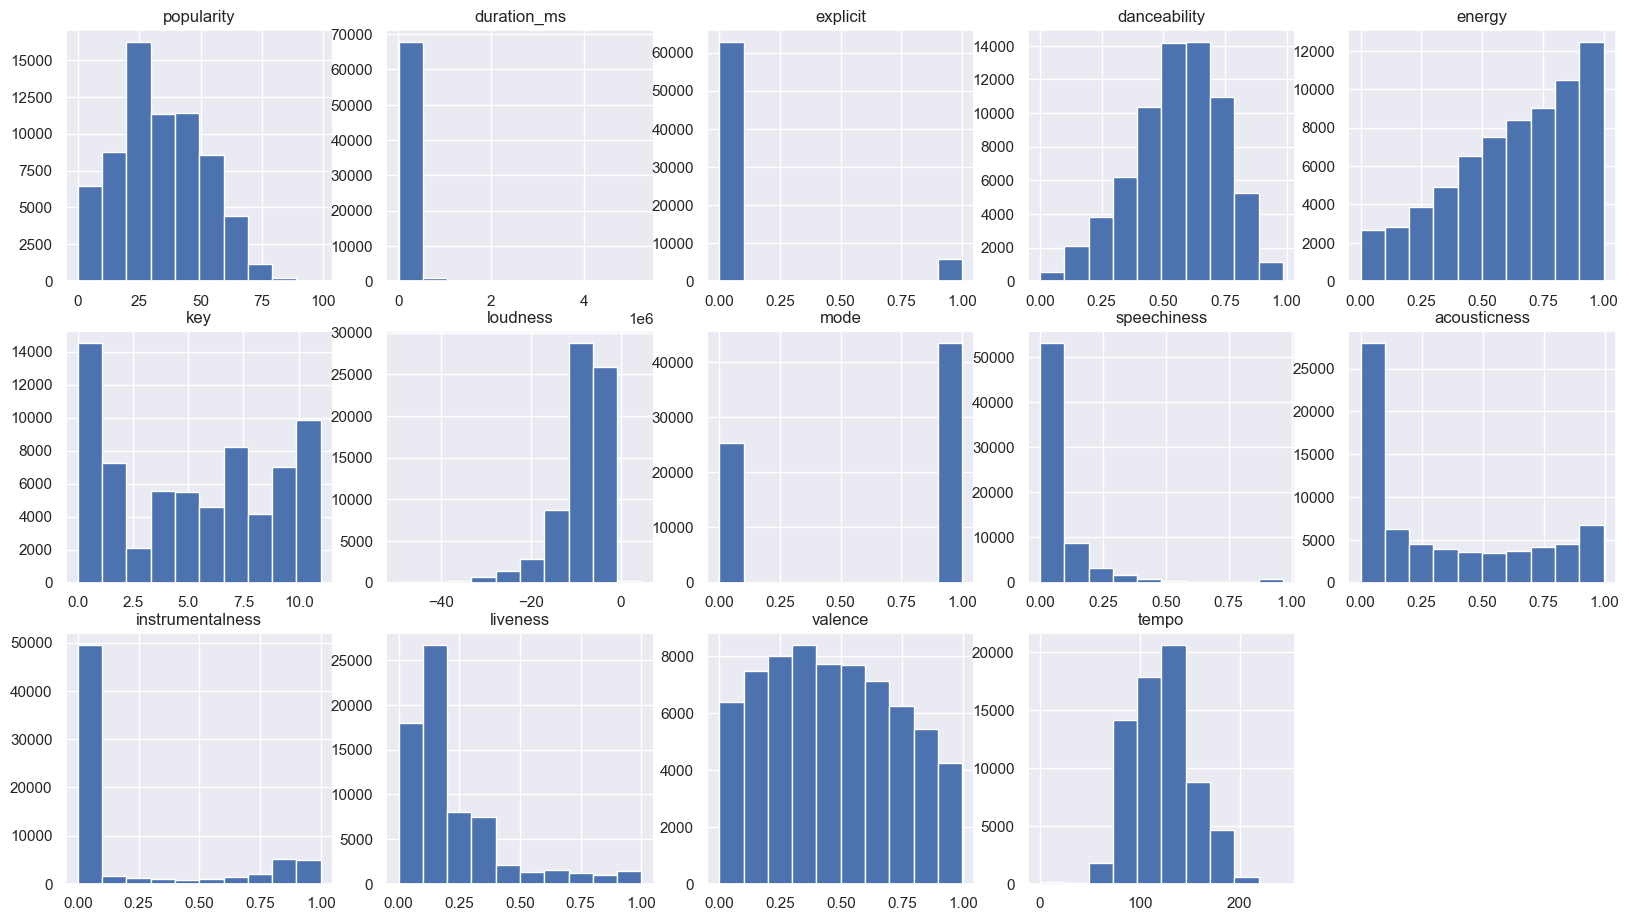

In [4]:
#Plotting feature histograms
features = ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo']

plt.figure(figsize=(20, 15))
for i in range(len(features)):
  plt.subplot(4, 5, i+1)
  plt.hist(np.array(df[features[i]]))
  plt.title(features[i])
plt.show()

#### Analysis of Feature Histograms
1. Looking at the scales of each histogram, it's evident that most features are on different scales. Thus, some feature normalization would be beneficial to improve the performance of the model.
2. Based on how far the scale of x_axis goes on duration_ms, it shows that there are a small sample of songs far greater than the average length.

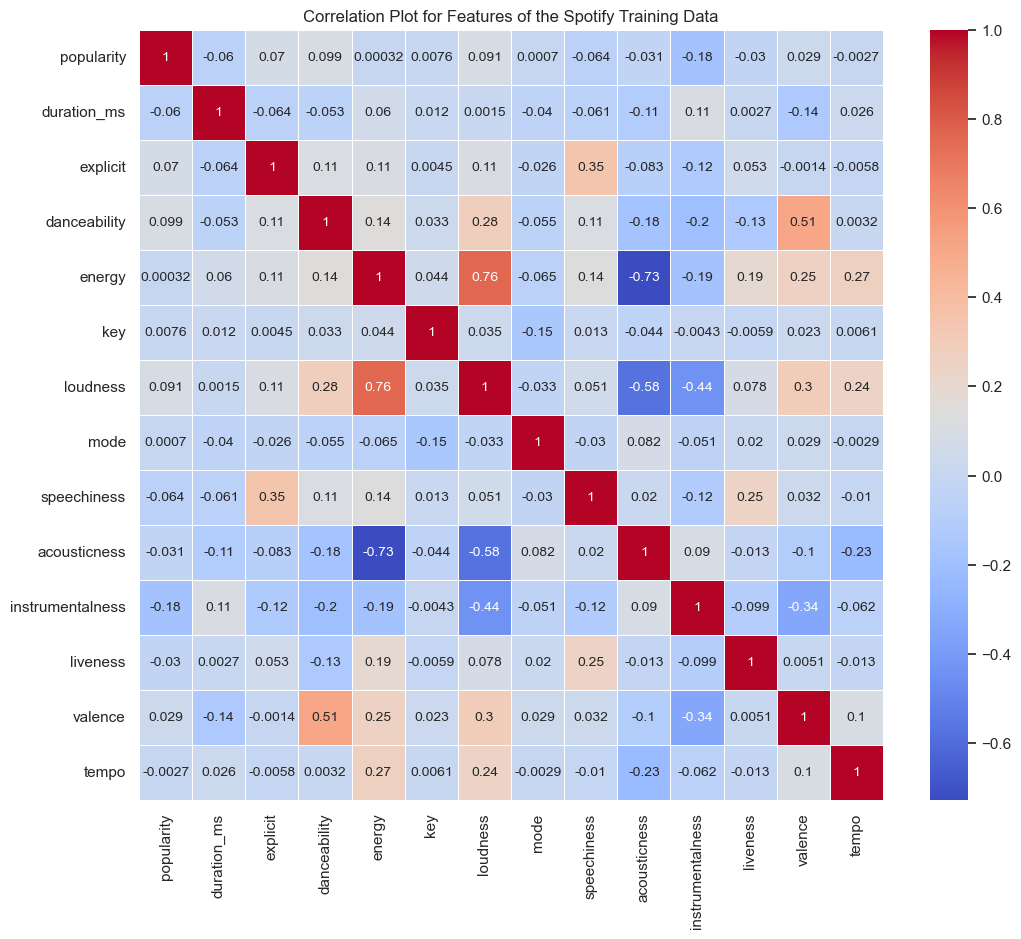

In [5]:
#Plotting correlation plot of the features
plt.figure(figsize=(12,10))
corr = df[features].corr()
sns.heatmap(corr, annot = True, cmap= 'coolwarm', linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Plot for Features of the Spotify Training Data')

plt.show()

#### Analysis of Correlation Plot
1. Based on the correlation plot, no two features seem extremely correlated with each other (~1.0). Thus, there are no redundant variables that may affect the model.
2. Popularity and duration_ms seem to have very low correlation with other acoustic features, which may indicate that they don't have a big impact on genre classification, compared to using the acoustic features. ### IDK IF I KEEP THIS STATEMENT IN HERE SINCE WE'RE USING THE FEATURES.
3. Speechiness and Explicit features have a weak positive correlation, but could be a good indicator for songs in the genre of Rap.
4. Acousticness has a moderate to high negative correlation with energy and loudness, showing that it could be a good indicator of different genres.

## Feature Engineering

In [6]:
# One hot encode key field
df = pd.get_dummies(df, columns=['key'], dtype=int)
df = df.rename(columns={"key_0":"C","key_1":"C#","key_2":"D","key_3":"D#","key_4":"E","key_5":"F",
                        "key_6":"F#","key_7":"G","key_8":"G#","key_9":"A","key_10":"A#","key_11":"B"})

df['popularity'] = df['popularity'].astype(int)
df['duration_ms'] = df['duration_ms'].astype(int)
df['mode'] = df['mode'].astype(int)

print(df.shape)
df.head()

(68682, 26)


,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,C,C#,D,D#,E,F,F#,G,G#,A,A#,B
2,57,210826,0,0.438,0.359,-9.734,1,0.0557,0.210,0.000000,0.117,0.120,76.332,acoustic,1,0,0,0,0,0,0,0,0,0,0,0
14,56,188133,0,0.755,0.780,-6.084,1,0.0327,0.124,0.000028,0.121,0.387,120.004,acoustic,0,0,1,0,0,0,0,0,0,0,0,0
18,68,189613,0,0.625,0.414,-8.700,1,0.0369,0.294,0.000000,0.151,0.669,130.088,acoustic,1,0,0,0,0,0,0,0,0,0,0,0
19,67,260186,0,0.717,0.320,-8.393,1,0.0283,0.830,0.000000,0.107,0.322,107.946,acoustic,0,0,0,1,0,0,0,0,0,0,0,0
21,63,174174,0,0.678,0.351,-8.654,1,0.0266,0.747,0.000000,0.355,0.569,90.032,acoustic,1,0,0,0,0,0,0,0,0,0,0,0


In [7]:
# Bin the popularity field
df['popularity_bin'] = pd.qcut(df.popularity,q=5,labels=[1,2,3,4,5])
df = pd.get_dummies(df, columns=['popularity_bin'], dtype=int)

# Remove tracks that are less than 60 seconds
df = df[df['duration_ms'] > 60000]

# Keep tracks with duration within 98th percentile
df = df[df['duration_ms'] < df['duration_ms'].quantile(.98)]

# Bin the duration_ms field
df['duration_bin'] = pd.qcut(df.duration_ms,q=4,labels=[1,2,3,4])
df = pd.get_dummies(df, columns=['duration_bin'], dtype=int)
df

,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,C,C#,D,D#,E,F,F#,G,G#,A,A#,B,popularity_bin_1,popularity_bin_2,popularity_bin_3,popularity_bin_4,popularity_bin_5,duration_bin_1,duration_bin_2,duration_bin_3,duration_bin_4
2,57,210826,0,0.438,0.359,-9.734,1,0.0557,0.210,0.000000,0.1170,0.1200,76.332,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
14,56,188133,0,0.755,0.780,-6.084,1,0.0327,0.124,0.000028,0.1210,0.3870,120.004,acoustic,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
18,68,189613,0,0.625,0.414,-8.700,1,0.0369,0.294,0.000000,0.1510,0.6690,130.088,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
19,67,260186,0,0.717,0.320,-8.393,1,0.0283,0.830,0.000000,0.1070,0.3220,107.946,acoustic,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
21,63,174174,0,0.678,0.351,-8.654,1,0.0266,0.747,0.000000,0.3550,0.5690,90.032,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,21,384999,0,0.172,0.235,-16.393,1,0.0422,0.640,0.928000,0.0863,0.0339,125.995,world-music,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
113996,22,385000,0,0.174,0.117,-18.318,0,0.0401,0.994,0.976000,0.1050,0.0350,85.239,world-music,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
113997,22,271466,0,0.629,0.329,-10.895,0,0.0420,0.867,0.000000,0.0839,0.7430,132.378,world-music,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
113998,41,283893,0,0.587,0.506,-10.889,1,0.0297,0.381,0.000000,0.2700,0.4130,135.960,world-music,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1


## Feature Selection

In [8]:
# Set features to use in model
features = [
    # 'popularity',
    # 'duration_ms',
    'explicit',
    'danceability',
    'energy',
    'loudness',
    # 'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    # 'C',
    # 'C#',
    # 'D',
    # 'D#',
    # 'E',
    # 'F',
    # 'F#',
    # 'G',
    # 'G#',
    # 'A',
    # 'A#',
    # 'B',
    'popularity_bin_1',
    'popularity_bin_2',
    'popularity_bin_3',
    'popularity_bin_4',
    'popularity_bin_5',
    'duration_bin_1',
    'duration_bin_2',
    'duration_bin_3',
    'duration_bin_4'
]

# Load tracks and genre labels
tracks = df[features]
labels = df['track_genre']
labels_count = len(labels.unique())

print("Shape of tracks ", tracks.shape)
print("Shape of labels ", labels.shape)

Shape of tracks  (66614, 19)
Shape of labels  (66614,)


## Data Shuffling

In [9]:
# Apply random shufflying to training examples.
np.random.seed(4)
indices = np.arange(tracks.shape[0])
shuffled_indices = np.random.permutation(indices)
tracks = tracks.iloc[shuffled_indices]
labels = labels.iloc[shuffled_indices]

## Data Normalizing - Does normalizing need to be done after split for proper train/test normalization?

In [10]:
# Encode the target variable
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Normalize the feature set
scaler = StandardScaler()
tracks_scaled = scaler.fit_transform(tracks)

## Data Splitting

In [11]:
# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(tracks_scaled, labels_encoded, test_size = 0.2, random_state=42)

# Print shapes of train and test data 
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', Y_train.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', Y_test.shape)

print('Check for any null values:', np.isnan(X_train).sum() + np.isnan(Y_train).sum() + np.isnan(X_test).sum() + np.isnan(Y_test).sum())

Shape of train images  (53291, 19)
Shape of train labels  (53291,)
Shape of test images  (13323, 19)
Shape of test labels  (13323,)
Check for any null values: 0


## Baseline Model

In [12]:
#show class distribution
unique, counts = np.unique(Y_train, return_counts = True)
class_counts = dict(zip(unique, counts))
class_counts

{0: 617,
 1: 696,
 2: 126,
 3: 78,
 4: 513,
 5: 516,
 6: 625,
 7: 746,
 8: 289,
 9: 218,
 10: 696,
 11: 424,
 12: 673,
 13: 656,
 14: 634,
 15: 432,
 16: 371,
 17: 729,
 18: 739,
 19: 414,
 20: 189,
 21: 494,
 22: 500,
 23: 401,
 24: 642,
 25: 456,
 26: 619,
 27: 696,
 28: 161,
 29: 207,
 30: 91,
 31: 158,
 32: 543,
 33: 431,
 34: 333,
 35: 706,
 36: 651,
 37: 361,
 38: 595,
 39: 406,
 40: 496,
 41: 607,
 42: 666,
 43: 419,
 44: 551,
 45: 680,
 46: 596,
 47: 288,
 48: 519,
 49: 723,
 50: 742,
 51: 346,
 52: 641,
 53: 103,
 54: 713,
 55: 389,
 56: 82,
 57: 177,
 58: 631,
 59: 658,
 60: 592,
 61: 672,
 62: 252,
 63: 271,
 64: 138,
 65: 594,
 66: 705,
 67: 138,
 68: 111,
 69: 752,
 70: 673,
 71: 107,
 72: 527,
 73: 452,
 74: 348,
 75: 627,
 76: 618,
 77: 499,
 78: 532,
 79: 512,
 80: 234,
 81: 509,
 82: 640,
 83: 455,
 84: 373,
 85: 148,
 86: 190,
 87: 296,
 88: 60,
 89: 56,
 90: 128,
 91: 514,
 92: 446,
 93: 686,
 94: 432,
 95: 744,
 96: 491,
 97: 632,
 98: 632,
 99: 539,
 100: 722,
 101

In [13]:
#stratified baseline implementation
dummy_clf = DummyClassifier(strategy = 'stratified', random_state = 42)
dummy_clf.fit(X_train, Y_train)
Y_pred = dummy_clf.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)

print(f'Baseline Classifier Accuracy: {accuracy}')
print(f'Classification Report: {report}')

Baseline Classifier Accuracy: 0.011558958192599264
Classification Report:               precision    recall  f1-score   support

           0       0.01      0.01      0.01       179
           1       0.02      0.02      0.02       185
           2       0.00      0.00      0.00        28
           3       0.00      0.00      0.00        15
           4       0.01      0.01      0.01       147
           5       0.03      0.03      0.03       120
           6       0.00      0.00      0.00       161
           7       0.02      0.02      0.02       194
           8       0.01      0.01      0.01        77
           9       0.00      0.00      0.00        50
          10       0.01      0.01      0.01       158
          11       0.02      0.02      0.02       105
          12       0.02      0.02      0.02       164
          13       0.01      0.01      0.01       146
          14       0.01      0.01      0.01       169
          15       0.00      0.00      0.00       131
       

#### Baseline Analysis
Using a stratified dummy classifier as a baseline model, the classifier tries to retain the distribution of classes, while randomly assigning labels to each track. As shown, the accuracy is extremely low, at around 0.01. Thus there is a lot of room for improvement regarding feature selection, engineering, and fixing class distributions.

## KNN

## Clustering

At this point, it is clear that the unique genres in our data may actually make up a hierarchy, with some "parent" genres and some "children" sub-genres. For example, Alt-rock, Punk-rock, and Hard-rock can all reasonably be considered sub-genres of Rock. To determine if our inability to produce accurate classifications was due to the large number of classes, we turned our attention to reducing the number of unique genres. 

While some information and nuance will be lost by reducing the overall number of classes, there are several benefits. This will significantly help to minimize the possibility of overfitting on the training data, which will also help improve generalization when we begin to introduce new data.   

For our first attempt at genre simplification, we performed a clustering activity.

C:\Users\linni\anaconda3\envs\ds207\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


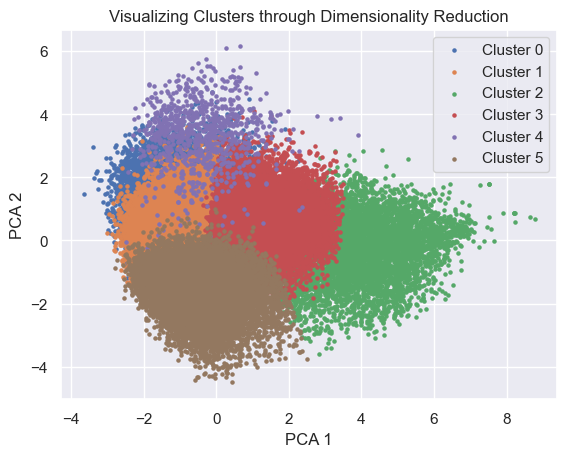

In [14]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Prepare data for clustering
cluster_data = df.drop(columns=['track_genre'])[['popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness','liveness', 'valence', 'tempo']]

scaled_features = scaler.fit_transform(cluster_data)

# Define number of clusters 
number_of_clusters = 6
kmeans = KMeans(n_clusters = number_of_clusters, random_state = 48)
cluster_data['cluster'] = kmeans.fit_predict(scaled_features)

#Principal component analysis (dimensionality reduction) for visualisation
pca = PCA(n_components=2)
cluster_reduced = pca.fit_transform(scaled_features)

# Visualize the clusters through a scatter plot
for i in range(number_of_clusters):
    idx = cluster_data['cluster'] == i
    plt.scatter(cluster_reduced[idx, 0], cluster_reduced[idx, 1], label=f'Cluster {i}', alpha = 1, s=5)

plt.title('Visualizing Clusters through Dimensionality Reduction')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

<Axes: xlabel='cluster'>

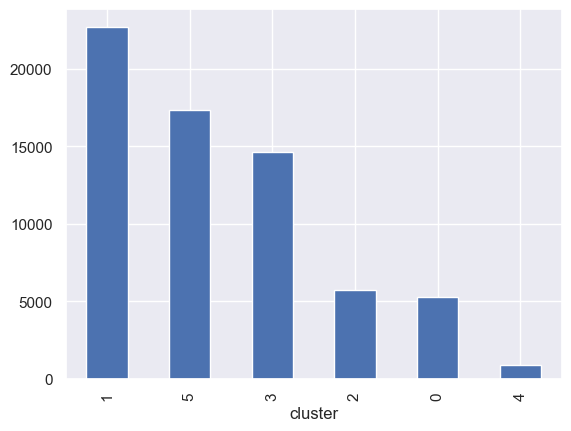

In [15]:
cluster_data['cluster'].value_counts().plot(kind = 'bar')

In [16]:
print('Number of unique genres in')
for i in range(number_of_clusters):
    print('Cluster',i,':',len(df[cluster_data['cluster']==i]['track_genre'].unique()))

Number of unique genres in
Cluster 0 : 100
Cluster 1 : 111
Cluster 2 : 67
Cluster 3 : 110
Cluster 4 : 46
Cluster 5 : 111


#### Clustering Outcome
In order to better visualize our clusters, we performed principal component analysis - this is a dimensionality reduction activity that captures the largest variations in the data. It appears that there is some overlap across the clusters. Investigating further, the clustering activity did not isolate genres into single clusters - most genres are present across multiple clusters. This held true while experimenting with different cluster sizes. 

While the clusters may contain tracks with similar characteristics, this does not necessarily seem to be helpful from a "genre classification" standpoint. We are interested in building a model that will learn the characteristics and relationships within specific genres, so it would not be helpful to separate tracks with the same genre into different clusters. Therefore, we have decided not to move forward with the genre aggregation created through clustering. . 

## Research & Manual Genre Mapping

After some research and investigation, our next attempt at genre simplification was through a manual genre hierarchy mapping. For this mapping, we focused our attention on the most prolific genres, as defined in several [resources](https://rateyourmusic.com/genres/).These categories include: Rock, Pop, Electronic Dance Music, Hip-Hop/R&B, Country, Latin & Reggaeton, and Classical. 

In [17]:
genre_to_category = {
    # EDM
    'edm': 'Electronic Dance Music', 
    'techno': 'Electronic Dance Music', 
    'drum-and-bass': 'Electronic Dance Music', 
    'progressive-house': 'Electronic Dance Music', 
    
    # Rock
    'alt-rock': 'Rock', 
    'rock': 'Rock', 
    'punk': 'Rock', 
    'hard-rock': 'Rock', 
    'metal': 'Rock', 
    'heavy-metal': 'Rock', 
    
    # Hip-Hop and R&B
    'hip-hop': 'Hip-Hop and R&B', 
    'r-n-b': 'Hip-Hop and R&B', 
    'funk': 'Hip-Hop and R&B',
    'trap': 'Hip-Hop and R&B',

    # Country
    'country': 'Country',
    'bluegrass': 'Country',
    'honky-tonk': 'Country',

    # Classical
    'classical': 'Classical', 
    'opera': 'Classical', 
    
    # Pop
    'pop': 'Pop', 
    'k-pop': 'Pop', 
    'pop-film': 'Pop', 
    
    # Latin & Reggaeton
    'latin': 'Latin & Reggaeton', 
    'latino': 'Latin & Reggaeton', 
    'reggaeton': 'Latin & Reggaeton', 
    'salsa': 'Latin & Reggaeton',
    'samba': 'Latin & Reggaeton', 
}

# Map each track to a category
df['music_category'] = df['track_genre'].apply(lambda x: genre_to_category.get(x, 'Other'))

slim_df = df[df['music_category'] != 'Other']
slim_df.shape

(12282, 36)

### [YN Note] - for genre mapping, I am currently updating df and then recreating tracks & labels. This means then need to reshuffle, normalize and split again. Is there a better alternative? Labels was previously encoded, how would we map the new music categories to it, and remove "other" ? If we decide to just reshuffle, normalize, split, maybe we create functions above to minimize duplicate code? 

<Axes: ylabel='music_category'>

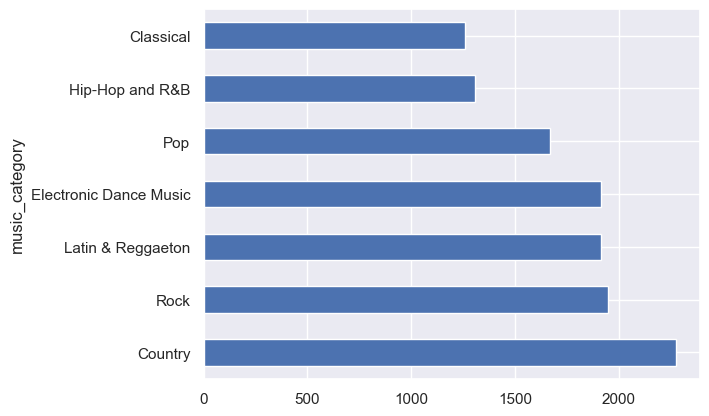

In [18]:
slim_df['music_category'].value_counts().plot(kind='barh')

In [19]:
slim_df['music_category'].value_counts()

music_category
Country                   2275
Rock                      1947
Latin & Reggaeton         1914
Electronic Dance Music    1912
Pop                       1670
Hip-Hop and R&B           1306
Classical                 1258
Name: count, dtype: int64

After our genre categorization, there is an uneven distribution of tracks. To remedy this, we will rebalance the classes such that there are an equivalent number of examples in each class.

In [20]:
# Load tracks and genre labels
tracks = slim_df[features]
labels = slim_df['music_category']
labels_count = len(labels.unique())

print("Shape of tracks ", tracks.shape)
print("Shape of labels ", labels.shape)

# Apply random shufflying to training examples.
np.random.seed(4)
indices = np.arange(tracks.shape[0])
shuffled_indices = np.random.permutation(indices)
tracks = tracks.iloc[shuffled_indices]
labels = labels.iloc[shuffled_indices]

Shape of tracks  (12282, 19)
Shape of labels  (12282,)


## Class Distribution Fixing

In [21]:
min_count = labels.value_counts().min()
result = {}
unique_classes = np.unique(labels)
for value in unique_classes:
    indices = np.where(labels==value)[0][:min_count]
    result[value] = indices.tolist()
index_values = list(result.values())
index_values = [element for nestedlist in index_values for element in nestedlist]
# tracks_scaled = tracks_scaled[index_values]
# labels_encoded = labels_encoded[index_values]
tracks = tracks.iloc[index_values]
labels = labels.iloc[index_values]

<Axes: title={'center': 'Fixed Uniform Distribution of Genres'}, xlabel='Genres', ylabel='Samples'>

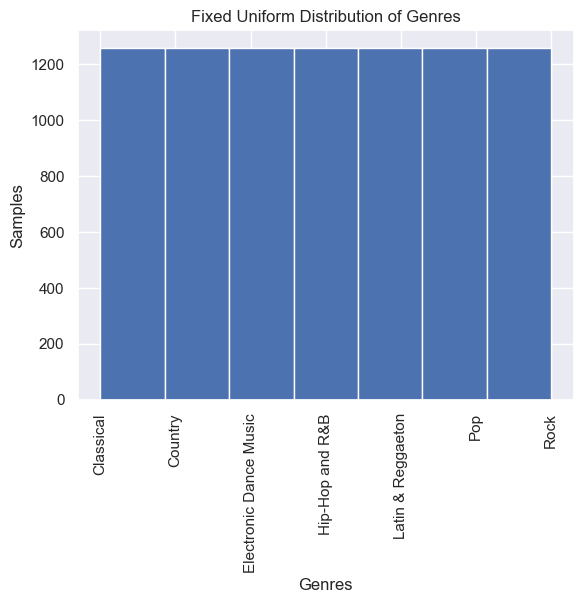

In [22]:
plt.figure()
plt.xticks(rotation = 90)
plt.title('Fixed Uniform Distribution of Genres')
plt.xlabel('Genres')
plt.ylabel('Samples')
labels.hist(bins=labels_count)

In [23]:
# Encode the target variable
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Normalize the feature set
scaler = StandardScaler()
tracks_scaled = scaler.fit_transform(tracks)

In [24]:
#Resplit
X_train, X_test, Y_train, Y_test = train_test_split(tracks_scaled, labels_encoded, test_size = 0.2, random_state=42)

# Print shapes of train and test data 
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', Y_train.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', Y_test.shape)

print('Check for any null values:', np.isnan(X_train).sum() + np.isnan(Y_train).sum() + np.isnan(X_test).sum() + np.isnan(Y_test).sum())

Shape of train images  (7044, 19)
Shape of train labels  (7044,)
Shape of test images  (1762, 19)
Shape of test labels  (1762,)
Check for any null values: 0


## KNN Revisted

## Decision Trees

With some improvement seen in KNN after performing genre reduction, we next built a Decision Tree to try and classify the tracks. After hyperarameter tuning, we found 17 estimators to be the ideal number of trees, with diminishing returns as we increased beyond that. Additionally, a max depth of 8 yielded the highest validation accuracy, without overfitting on the training data and maintaining a train/validation accuracy differential within 6%.

Model Accuracy on training set: 0.775
Model Accuracy on validation set: 0.701


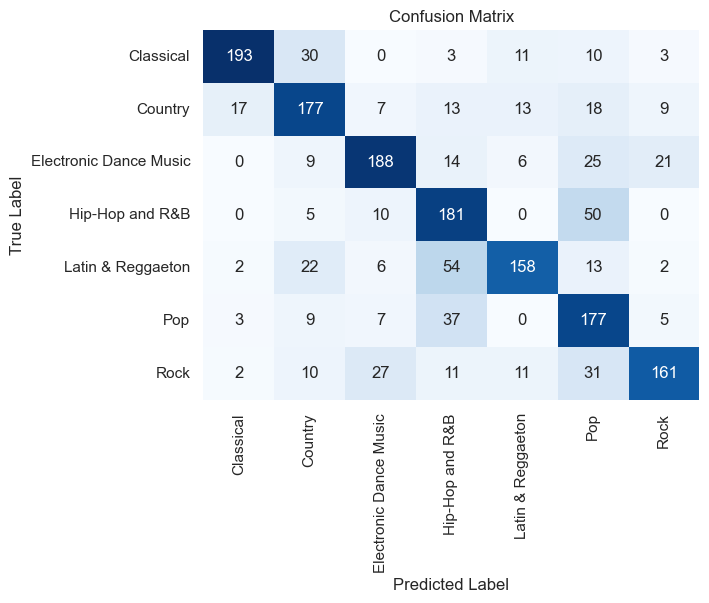

In [25]:
# Re-split the training set to get a validation set
X_train_dt, X_val_dt, Y_train_dt, Y_val_dt = train_test_split(X_train, Y_train, test_size = 0.25, random_state=42)

# Build RandomForestClassifier, and fit with X_Train_re, y_train
rf = RandomForestClassifier(
    n_estimators=17,
    n_jobs=1,
    random_state=7,
    max_depth=8,
    # max_features='log2'
)
rf.fit(X_train_dt, Y_train_dt)

# Evaluate model accuracy with X_train_re
print('Model Accuracy on training set:',round(rf.score(X_train_dt, Y_train_dt),3))  

# Evaluate model accuracy with X_val_re
print('Model Accuracy on validation set:',round(rf.score(X_val_dt, Y_val_dt),3))

# Plot Confusion Matrix using y_val, y_val_pred
Y_val_pred = rf.predict(X_val_dt)
cm = confusion_matrix(Y_val_dt, Y_val_pred)
ax = sns.heatmap(cm, annot=True, fmt='.3g', cmap='Blues', xticklabels=labels.unique(), yticklabels=labels.unique(), cbar=False)
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# Calculating precision and recall for each class
print('Precision and Recall per class\n')
for i in range(labels_count):
    precision = tf.keras.backend.get_value(cm[:,i][i]) / np.sum(tf.keras.backend.get_value(cm[:,i]))
    recall = tf.keras.backend.get_value(cm[:,i][i]) / np.sum(tf.keras.backend.get_value(cm[i,:]))
    print(round(precision,3), '|', round(recall,3),':',labels.unique()[i])

Precision and Recall per class

0.889 | 0.772 : Classical
0.676 | 0.697 : Country
0.767 | 0.715 : Electronic Dance Music
0.578 | 0.736 : Hip-Hop and R&B
0.794 | 0.615 : Latin & Reggaeton
0.546 | 0.744 : Pop
0.801 | 0.636 : Rock


Analyzing the confusion matrix above, it appears that Pop has the most false positives - the model is confusing a decent number of Hip-Hop/R&B tracks as Pop, with Pop having a precision of only 60%. The confusion matrix also reveals that Electronic Dance Music has a sizable amount of false negatives, with a recall of 65% - it seems there are a decent amount of Electronic Dance Music tracks that are being confused for Rock and Pop. 

## Neural Networks

#### Model 1: Single Layer

Next, we turned our attention to Neural Networks to try and improve our classification accuracy. We started with a simple model with a single layer.

In [27]:
def build_model_single(num_features, n_classes,learning_rate=0.01):
    """Build a TF logistic regression model using Keras.
    
    Args:
    learning_rate: The desired learning rate for SGD.
    
    Returns:
    model: A tf.keras model (graph).
    """
    # Random Seed + Clear Session
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # Build a model using keras.Sequential.
    model = keras.Sequential(name = 'Genres')
    
    # Keras layers processing
    model.add(tf.keras.layers.InputLayer(input_shape=num_features))
    
    # This layer constructs the linear set of parameters for each input feature
    # (as well as a bias), and applies a sigmoid to the result. The result is
    # binary logistic regression.
    model.add(keras.layers.Dense(
      units=n_classes,
      activation='softmax'))

    # Use the SGD optimizer as usual.
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    # We specify the binary_crossentropy loss (equivalent to log loss).
    # Notice that we are including 'binary accuracy' as one of the metrics that we
    # ask Tensorflow to report when evaluating the model.
    model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer, 
                metrics=['accuracy'])
    
    return model

In [28]:
model = build_model_single(num_features = X_train.shape[1], n_classes = labels_count)
model.summary()


Model: "Genres"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 140       
                                                                 
Total params: 140 (560.00 Byte)
Trainable params: 140 (560.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
# Fit the model.
history = model.fit(
  x = X_train,   # training examples
  y = Y_train,   #labels
  epochs=5,             # number of passes through the training data
  batch_size=128,        # mini-batch size for SGD
  validation_split=0.25, # use a fraction of the examples for validation -- DO WE STILL NEED THIS IF VALIDATION SPLIT
  verbose=1             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
display(history)

Epoch 1/5


42/42 [==============================] - 0s 4ms/step - loss: 2.1830 - accuracy: 0.1969 - val_loss: 2.0436 - val_accuracy: 0.2328
Epoch 2/5
42/42 [==============================] - 0s 1ms/step - loss: 1.9521 - accuracy: 0.2644 - val_loss: 1.8482 - val_accuracy: 0.2942
Epoch 3/5
42/42 [==============================] - 0s 1ms/step - loss: 1.7759 - accuracy: 0.3273 - val_loss: 1.6979 - val_accuracy: 0.3407
Epoch 4/5
42/42 [==============================] - 0s 1ms/step - loss: 1.6405 - accuracy: 0.3816 - val_loss: 1.5789 - val_accuracy: 0.3896
Epoch 5/5
42/42 [==============================] - 0s 1ms/step - loss: 1.5330 - accuracy: 0.4200 - val_loss: 1.4840 - val_accuracy: 0.4344


,loss,accuracy,val_loss,val_accuracy
0,2.183015,0.196858,2.043598,0.232822
1,1.952065,0.264433,1.848165,0.294151
2,1.775872,0.327276,1.697910,0.340715
3,1.640493,0.381601,1.578899,0.389551
4,1.533021,0.420027,1.484044,0.434412


#### Model 2: Multiple Layers
We then train a model with multiple layers, and perform some hyperperameter tuning, adjusting the learning rate, optimization, number of epochs, and batch size. We found that a learning rate of 0.1, SGD optimization, 15 epochs, and batch size of 128 yielded minimal loss and the highest validation accuracy without overfitting on the training data. The differential between training and validation accuracy after 15 epochs is less than 1%. 

In [30]:
def build_model_multi(num_features, n_classes,learning_rate=.1):
    """Build a TF logistic regression model using Keras.
    
    Args:
    learning_rate: The desired learning rate for SGD.
    
    Returns:
    model: A tf.keras model (graph).
    """
    # Random Seed + Clear Session
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # Build a model using keras.Sequential.
    model = keras.Sequential(name = 'Genres')
    
    # Keras layers processing
    model.add(tf.keras.layers.InputLayer(input_shape=num_features))

    #adding extra layer
    model.add(keras.layers.Dense(
            units=256,
            activation = 'relu'))

    #adding extra layer
    model.add(keras.layers.Dense(
            units=128,
            activation = 'relu'))
    
    # This layer constructs the linear set of parameters for each input feature
    # (as well as a bias), and applies a sigmoid to the result. The result is
    # binary logistic regression.
    model.add(keras.layers.Dense(
      units=n_classes,
      activation='softmax'))

    # Use the SGD optimizer as usual.
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    # We specify the binary_crossentropy loss (equivalent to log loss).
    # Notice that we are including 'binary accuracy' as one of the metrics that we
    # ask Tensorflow to report when evaluating the model.
    model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer, 
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    return model

In [31]:
model = build_model_multi(num_features = X_train.shape[1], n_classes = labels_count)
model.summary()

Model: "Genres"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5120      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 7)                 903       
                                                                 
Total params: 38919 (152.03 KB)
Trainable params: 38919 (152.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
# Fit the model.
history = model.fit(
  x = X_train,   # training examples
  y = Y_train,   #labels
  epochs=15,             # number of passes through the training data
  batch_size=128,        # mini-batch size for SGD
  validation_split=0.25, # use a fraction of the examples for validation -- DO WE STILL NEED THIS IF VALIDATION SPLIT
  verbose=0             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
display(history)

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
0,1.390319,0.556881,1.017370,0.673481
1,0.924493,0.691274,0.855562,0.701874
2,0.837285,0.704713,0.822103,0.714367
3,0.804918,0.714178,0.790137,0.725724
4,0.780675,0.721560,0.780687,0.734242
5,0.763125,0.727238,0.768759,0.727428
6,0.746862,0.731213,0.760506,0.729699
7,0.735155,0.738595,0.743216,0.739920
8,0.724059,0.734999,0.739483,0.737081
9,0.714007,0.740867,0.735729,0.738217


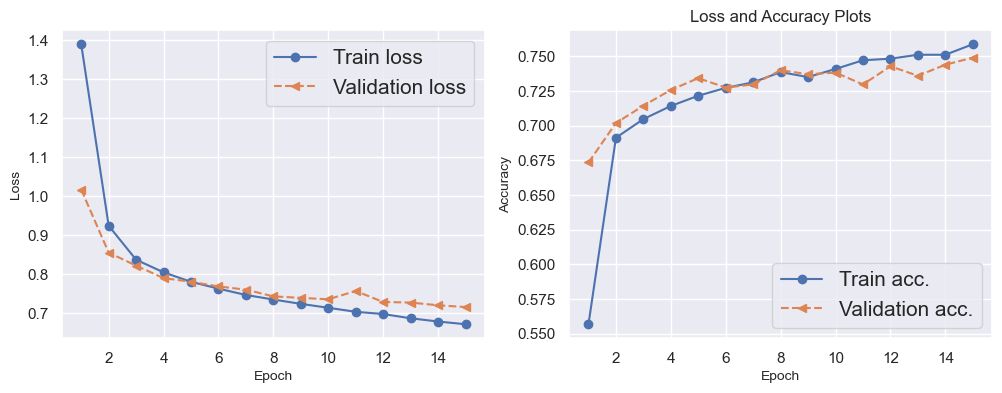

In [33]:
epoch_list = np.arange(len(history['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(epoch_list, history['loss'], '-o', label='Train loss')
ax.plot(epoch_list, history['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=10)
ax.set_ylabel('Loss', size=10)

ax = fig.add_subplot(1, 2, 2)
ax.plot(epoch_list, history['sparse_categorical_accuracy'], '-o', label='Train acc.')
ax.plot(epoch_list, history['val_sparse_categorical_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=10)
ax.set_ylabel('Accuracy', size=10)
plt.title('Loss and Accuracy Plots')
plt.show()

56/56 [==============================] - 0s 673us/step


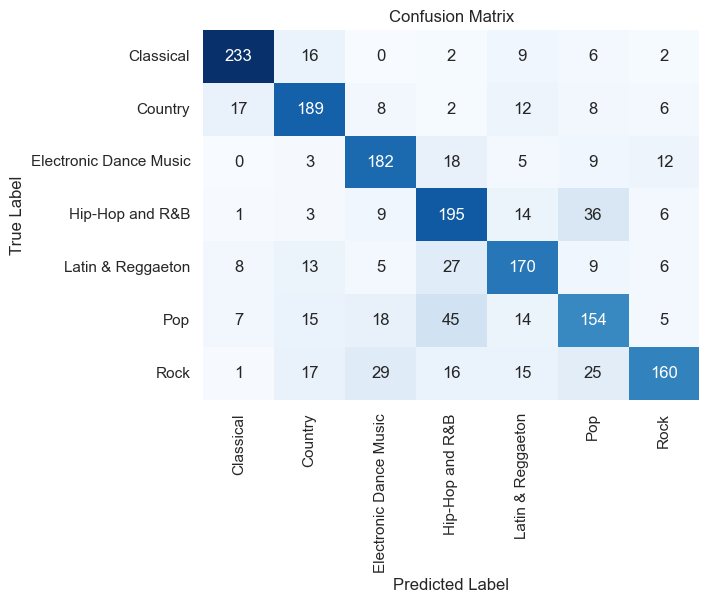

In [34]:
# Recall that model.predict gives a vector of probabilities for each x.
# Get labels by taking the argmax -- the index with the largest probability.
test_predictions = np.argmax(model.predict(X_test), axis=-1)

# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(Y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=labels.unique(), yticklabels=labels.unique(), cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix')
plt.show()

In [35]:
# Calculating precision and recall for each class
print('Precision and Recall per class\n')
for i in range(labels_count):
    precision = tf.keras.backend.get_value(confusion_matrix[:,i][i]) / np.sum(tf.keras.backend.get_value(confusion_matrix[:,i]))
    recall = tf.keras.backend.get_value(confusion_matrix[:,i][i]) / np.sum(tf.keras.backend.get_value(confusion_matrix[i,:]))
    print(round(precision,3), '|', round(recall,3),':',labels.unique()[i])

Precision and Recall per class

0.873 | 0.869 : Classical
0.738 | 0.781 : Country
0.725 | 0.795 : Electronic Dance Music
0.639 | 0.739 : Hip-Hop and R&B
0.711 | 0.714 : Latin & Reggaeton
0.623 | 0.597 : Pop
0.812 | 0.608 : Rock


#### ??? Should we be doing more models, for example a model with just 1 feature then add more features? Or maybe before and after some of the processing we did to help increase performance? For example, we removed top/bottom duration_ms which helped reduce confusion between pop and classical, etc?

Our mutli-layer neural network yielded slightly higher validation accuracy of 75% over the decision tree model, which had a validation accuracy of 72%. It appears that the hidden layers of the neural network had success in understanding the relationships between the features, improving the validation accuracy without overfitting on the training data.

Next, we evaluated the model's performance on the test data to determine how well the model was able to gernalize to new data. We can see here that the testing accuracy is around 72%, and while this is slightly below our validation accuracy, it gives us confidence that our model is able to generalize well with new data.

In [36]:
test_accuracy = model.evaluate(x=X_test, y=Y_test, verbose=0,return_dict=True)['sparse_categorical_accuracy']
print('Test Accuracy for multi-layer model:', round(test_accuracy,3))

Test Accuracy for multi-layer model: 0.728


## Conclusion